# Ethereum Price Estimation with Recurrent Neural Networks

In [ ]:
!pip install fastquant

     |████████████████████████████████| 5.3MB 6.2MB/s 
     |████████████████████████████████| 6.3MB 26.9MB/s 
     |████████████████████████████████| 419kB 31.9MB/s 
     |████████████████████████████████| 1.5MB 23.0MB/s 
     |████████████████████████████████| 512kB 39.5MB/s 
     |████████████████████████████████| 194kB 41.3MB/s 
     |████████████████████████████████| 122kB 48.6MB/s 
     |████████████████████████████████| 143kB 50.1MB/s 
     |████████████████████████████████| 2.0MB 34.8MB/s 
     |████████████████████████████████| 143kB 47.4MB/s 
     |████████████████████████████████| 645kB 30.7MB/s 
     |████████████████████████████████| 102kB 12.7MB/s 
     |████████████████████████████████| 7.2MB 31.1MB/s 
     |████████████████████████████████| 3.2MB 24.8MB/s 
     |████████████████████████████████| 1.3MB 29.0MB/s 
     |████████████████████████████████| 296kB 46.9MB/s 
     |████████████████████████████████| 747kB 36.1MB/s 
     |████████████████████████████████| 348kB 50.

In the cell below, select the start and end dates in a way that includes the last thousand days. The dates below are chosen for better understanding.

Please note that your dataset should cover the last thousand days from the time the code was put in place.

In this stage, information from the past thousand days of Ethereum and Bitcoin cryptocurrencies has been extracted. This includes daily data such as opening price, closing price, highest price, lowest price, and trading volume.

In [ ]:
from fastquant import get_crypto_data
crypto = get_crypto_data("ETH/USDT", "2018-09-09", "2021-06-04")
print(crypto.index)
crypto1 = get_crypto_data("BTC/USDT", "2018-09-09", "2021-06-04")

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


DatetimeIndex(['2018-09-09', '2018-09-10', '2018-09-11', '2018-09-12',
               '2018-09-13', '2018-09-14', '2018-09-15', '2018-09-16',
               '2018-09-17', '2018-09-18',
               ...
               '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
               '2021-05-30', '2021-05-31', '2021-06-01', '2021-06-02',
               '2021-06-03', '2021-06-04'],
              dtype='datetime64[ns]', name='dt', length=1000, freq=None)


Text(0.5, 1.0, 'Daily Closing Price of ETH/USDT')

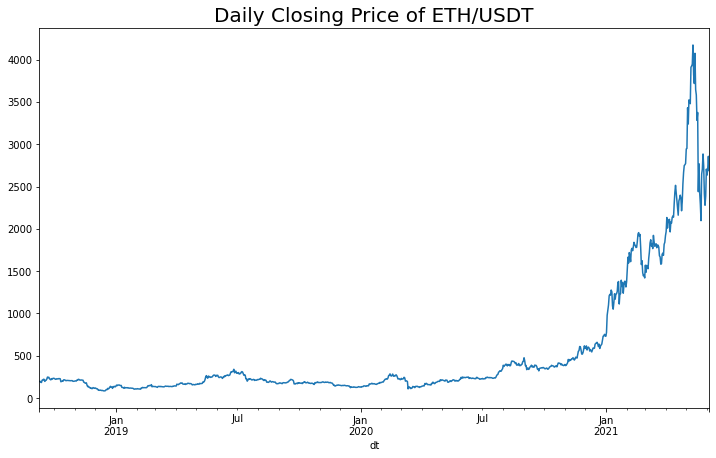

In [ ]:
from matplotlib import pyplot as plt
crypto.close.plot(figsize=(12, 7))
plt.title("Daily Closing Price of ETH/USDT", fontsize=20)

Next, we plot the chart of changes in Bitcoin's closing price.

Text(0.5, 1.0, 'Daily Closing Price of ETH/USDT')

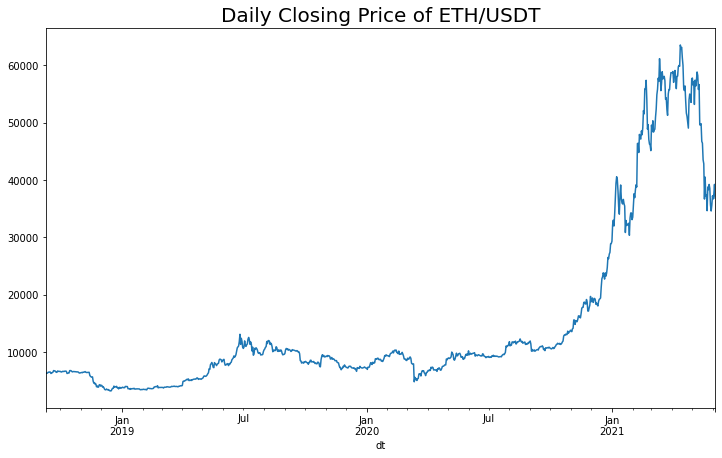

In [ ]:
from matplotlib import pyplot as plt
crypto1.close.plot(figsize=(12, 7))
plt.title("Daily Closing Price of ETH/USDT", fontsize=20)

In [ ]:
crypto.head()

,open,high,low,close,volume
dt,,,,,
2018-09-09,196.87,208.60,185.02,195.81,429255.02592
2018-09-10,196.13,203.42,187.10,197.15,418489.86663
2018-09-11,197.22,200.20,176.16,185.18,476745.79216
2018-09-12,185.14,185.22,167.32,183.12,504047.79165
2018-09-13,183.17,215.00,183.15,210.68,739503.34051


In [ ]:
crypto1.head()

,open,high,low,close,volume
dt,,,,,
2018-09-09,6185.06,6441.00,6141.53,6250.81,37053.923820
2018-09-10,6252.26,6373.98,6221.00,6312.00,32439.456432
2018-09-11,6311.99,6404.00,6169.68,6294.91,33104.888590
2018-09-12,6293.00,6360.00,6192.37,6338.62,31433.645939
2018-09-13,6338.62,6535.00,6337.40,6487.38,40465.063107


At this stage, various features of Ethereum and Bitcoin can be selected for input to the recurrent network. Here, only the 'close' column of Ethereum has been used.

In [ ]:
import numpy as np
#print(crypto.close[0:5])
L=[]
FullData=crypto[['close']].values
print(FullData[0:5])
#bitcoin=crypto1[['low']].values
#print(bitcoin[0:5])
#L=np.concatenate((FullData, bitcoin), axis=1)

[[195.81]
 [197.15]
 [185.18]
 [183.12]
 [210.68]]


At this stage, the data is normalized. MinMaxScaler normalizes the data to the range of 0 to 1. Since a recurrent network is also a type of neural network, normalizing the input data helps the network converge faster. Below, you can see the first five rows of the input data after normalization.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc=MinMaxScaler()
DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
##########
sc1=MinMaxScaler()
close=FullData[:,0]
close=np.reshape(close,(-1,1))
DataScaler1=sc1.fit(close)
N=DataScaler1.transform(close)

print("After Normalization",X[0:5])


After Normalization [[0.02739816]
 [0.02772582]
 [0.02479895]
 [0.02429524]
 [0.03103414]]


<div dir='rtl'style="text-align: right;font-family:verdana;">


At this stage, the parameter value for the lookback window is determined. Based on this, input and target data are extracted. Here, a window of length 'lookback' specifies consecutive data points that together form a sample, indicating how many past time steps are used to predict the next time step value. Recurrent networks accept three-dimensional inputs, so the input shape changes as follows: the first dimension represents the number of data points, the second dimension is the size of the lookback, and the third dimension is the number of features.

Similarly, the output shape also changes to represent the number of data points and the number of features (which is one in this problem).

It's important to note that at this stage, the total number of data points is reduced by the size of the lookback. This is because we do not have an output for the last 'lookback' data points.

The lookback size varied from 20 to 2 with a step of 5. For each value, the network was trained, and the error on the test data was calculated. The value 2 showed the minimum error on the test data.

In [ ]:
import numpy as np
#NumerOfRows = len(X)
lookback=2

X_train = []
Y_train = []

for i in range(lookback, X.shape[0]):

  X_train.append(X[i-lookback:i])

  Y_train.append(X[i,0])

  X_data, y_data = np.array(X_train), np.array(Y_train)
  X_data.shape

# Reshape the Input (number of samples, Time Steps, Features)

X_data=X_data.reshape(X_data.shape[0],X_data.shape[1],1)
print( "Input Data shape :",X_data.shape)


# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=y_data.reshape(y_data.shape[0], 1)
print(" Output Data shape:",y_data.shape)


Input Data shape : (998, 2, 1)
 Output Data shape: (998, 1)


In this section, the data is divided into two parts: training and testing sets. The last 100 data points are set aside for testing.

In [ ]:
#number of testing data
numtest=100

# Splitting the data into train and test
X_train=X_data[:-numtest]
X_test=X_data[-numtest:]
y_train=y_data[:-numtest]
y_test=y_data[-numtest:]

# new shape of training and testing
print('\n X train shape: ',X_train.shape)
print(' Y train shape: ',y_train.shape)


print('\n X test shape: ',X_test.shape)
print(' Y test shape: ',y_test.shape)



 X train shape:  (898, 2, 1)
 Y train shape:  (898, 1)

 X test shape:  (100, 2, 1)
 Y test shape:  (100, 1)


The number of time steps, which is equal to the lookback window, and the number of input features are extracted. This information is then used to define the input shape for LSTM.

In [ ]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 2
Number of Features: 1


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Here, a four-layer LSTM network is defined. return_sequences=True indicates that the output of each time step should be shared with the next hidden layer. Approximately 100 data points are set aside for validation. The Adam optimizer and a batch size of five are used. Next, we train this network and observe the results obtained.

In [ ]:
regressor = Sequential()

regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

regressor.add(LSTM(units = 5, activation = 'relu',  return_sequences=True))

regressor.add(LSTM(units = 5, activation = 'relu',  return_sequences=False))
# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['mae'])



In [ ]:
history=regressor.fit(X_train, y_train, batch_size = 5,validation_split=0.1, epochs = 20,verbose=2)

Epoch 1/20
161/161 - 7s - loss: 4.8463e-04 - mae: 0.0164 - val_loss: 0.0522 - val_mae: 0.1995
Epoch 2/20
161/161 - 1s - loss: 1.3284e-04 - mae: 0.0082 - val_loss: 0.0272 - val_mae: 0.1362
Epoch 3/20
161/161 - 1s - loss: 4.5397e-05 - mae: 0.0048 - val_loss: 0.0271 - val_mae: 0.1368
Epoch 4/20
161/161 - 1s - loss: 3.8376e-05 - mae: 0.0044 - val_loss: 0.0212 - val_mae: 0.1182
Epoch 5/20
161/161 - 1s - loss: 3.7117e-05 - mae: 0.0043 - val_loss: 0.0180 - val_mae: 0.1069
Epoch 6/20
161/161 - 1s - loss: 3.4392e-05 - mae: 0.0042 - val_loss: 0.0173 - val_mae: 0.1049
Epoch 7/20
161/161 - 1s - loss: 3.3117e-05 - mae: 0.0041 - val_loss: 0.0149 - val_mae: 0.0962
Epoch 8/20
161/161 - 1s - loss: 3.8216e-05 - mae: 0.0046 - val_loss: 0.0140 - val_mae: 0.0926
Epoch 9/20
161/161 - 1s - loss: 3.2612e-05 - mae: 0.0041 - val_loss: 0.0140 - val_mae: 0.0936
Epoch 10/20
161/161 - 1s - loss: 3.6486e-05 - mae: 0.0045 - val_loss: 0.0145 - val_mae: 0.0960
Epoch 11/20
161/161 - 1s - loss: 3.1772e-05 - mae: 0.0040 -

The loss plot obtained for training and validation data shows that the training loss is decreasing, indicating the model is not underfitting and the number of neurons and hidden layers are appropriate. As observed, there is a significant difference in the error rates between training and validation data, suggesting that adding dropout layers could mitigate this difference to some extent.

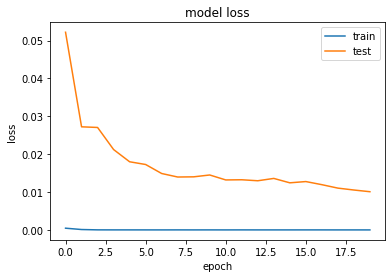

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Here, by inputting test samples into the trained model, the Mean Absolute Error (MAE) of this model is approximately 0.2.

In [ ]:
regressor.evaluate(X_test,y_test)

4/4 [==============================] - 1s 4ms/step - loss: 0.0724 - mae: 0.2007


[0.07243333011865616, 0.2007397711277008]

Here, you can see the plot of actual prices versus predicted prices for 100 test data points.

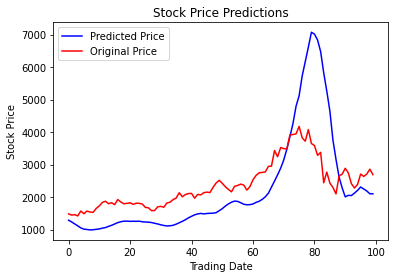

In [ ]:
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler1.inverse_transform(predicted_Price)
orig=DataScaler1.inverse_transform(y_test)

from matplotlib import pyplot as plt
plt.plot(predicted_Price, color = 'blue', label = 'Predicted Price')
plt.plot(orig , color = 'red', label = 'Original Price')
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
plt.show()

The chart below shows the actual prices and the predicted prices for all data points (both training and test data).

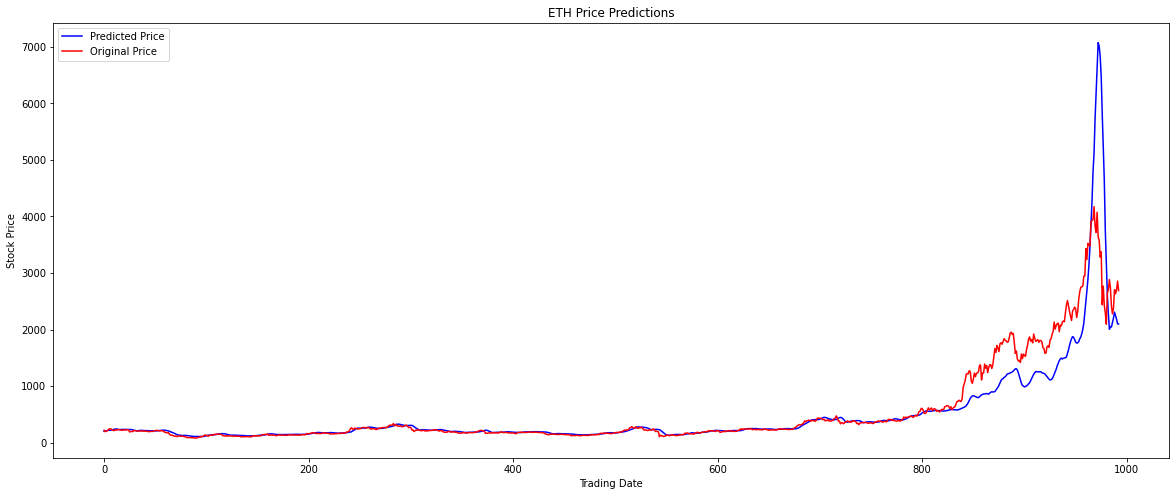

In [ ]:
# Generating predictions on full data
TrainPredictions=DataScaler1.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler1.inverse_transform(regressor.predict(X_test))

FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:,0]

# plotting the full data
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'red', label = 'Original Price')

plt.title('ETH Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

Here, we add Dropout layers to the previous model and retrain the new model.

In [ ]:
regressor = Sequential()

regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
regressor.add(Dropout(0.25))
regressor.add(LSTM(units = 5, activation = 'relu',  return_sequences=True))
regressor.add(Dropout(0.15))
regressor.add(LSTM(units = 5, activation = 'relu',  return_sequences=False))
regressor.add(Dropout(0.15))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['mae'])

In [ ]:
history=regressor.fit(X_train, y_train, batch_size = 5,validation_split=0.1, epochs = 15,verbose=2)

Epoch 1/15
162/162 - 7s - loss: 5.6569e-04 - mae: 0.0178 - val_loss: 0.0625 - val_mae: 0.2227
Epoch 2/15
162/162 - 1s - loss: 4.9665e-04 - mae: 0.0168 - val_loss: 0.0545 - val_mae: 0.2067
Epoch 3/15
162/162 - 1s - loss: 4.1065e-04 - mae: 0.0153 - val_loss: 0.0202 - val_mae: 0.1299
Epoch 4/15
162/162 - 1s - loss: 2.2148e-04 - mae: 0.0103 - val_loss: 0.0236 - val_mae: 0.0969
Epoch 5/15
162/162 - 1s - loss: 1.8215e-04 - mae: 0.0091 - val_loss: 0.0271 - val_mae: 0.1031
Epoch 6/15
162/162 - 1s - loss: 1.8155e-04 - mae: 0.0091 - val_loss: 0.0093 - val_mae: 0.0649
Epoch 7/15
162/162 - 1s - loss: 1.8415e-04 - mae: 0.0090 - val_loss: 0.0218 - val_mae: 0.0934
Epoch 8/15
162/162 - 1s - loss: 1.7204e-04 - mae: 0.0088 - val_loss: 0.0085 - val_mae: 0.0597
Epoch 9/15
162/162 - 1s - loss: 1.6642e-04 - mae: 0.0087 - val_loss: 0.0082 - val_mae: 0.0599
Epoch 10/15
162/162 - 1s - loss: 1.6279e-04 - mae: 0.0085 - val_loss: 0.0047 - val_mae: 0.0479
Epoch 11/15
162/162 - 1s - loss: 1.8085e-04 - mae: 0.0092 -

As observed, after adding the Dropout layer, the validation error has decreased.

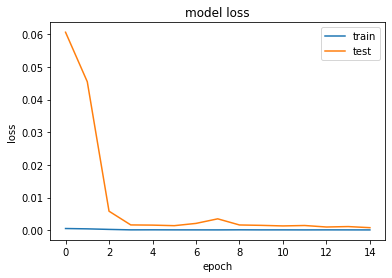

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

We feed the test data into the new model and obtain a mean absolute error (MAE) of 0.066 for these samples.

In [ ]:
regressor.evaluate(X_test,y_test)

4/4 [==============================] - 1s 4ms/step - loss: 0.0115 - mae: 0.0661


[0.011451301164925098, 0.06614638864994049]

You can see the chart of the actual price and the predicted price for the test data, as estimated by the new model.

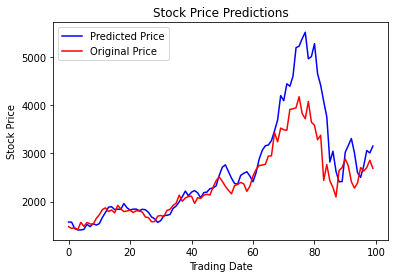

In [ ]:
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler1.inverse_transform(predicted_Price)
orig=DataScaler1.inverse_transform(y_test)
from matplotlib import pyplot as plt
plt.plot(predicted_Price, color = 'blue', label = 'Predicted Price')
plt.plot(orig , color = 'red', label = 'Original Price')
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
plt.show()

You can see the chart of the actual price and the predicted price for all data (both test and training) below.

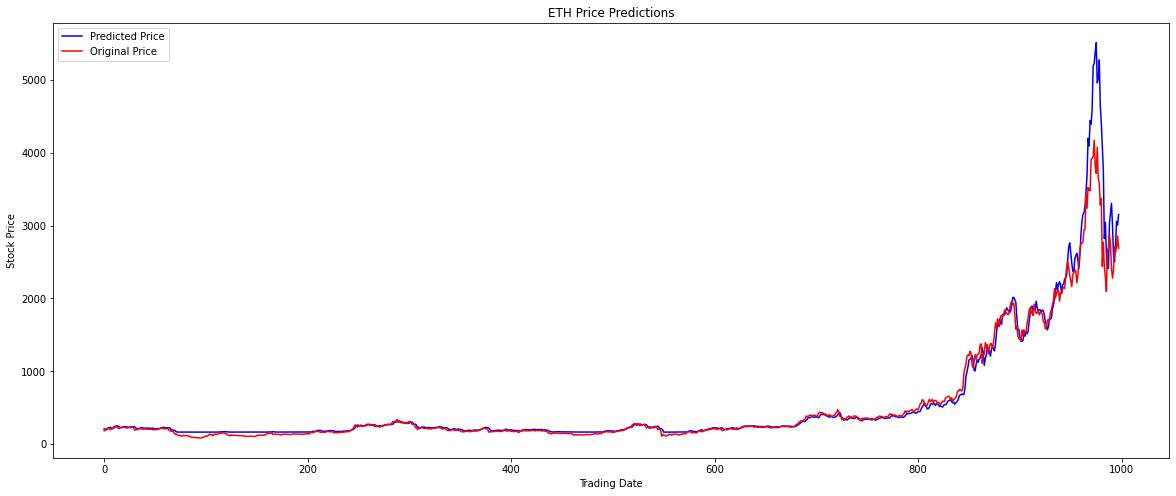

In [ ]:
# Generating predictions on full data
TrainPredictions=DataScaler1.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler1.inverse_transform(regressor.predict(X_test))

FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:,0]

# plotting the full data
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'red', label = 'Original Price')


plt.title('ETH Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

This model was also trained using other features such as the opening price, highest price, lowest price, as well as the closing price of Bitcoin. However, the final error increased from 0.06.